In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")
import data_loading as dl

from microfit import run_plotter as rp
from microfit import histogram as hist

In [3]:
RUN = ["3"]

rundata_numu, mc_weights_numu, data_pot_numu = dl.load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue", "drt"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    numupresel=True,
    loadnumuvariables=True,
    load_crt_vars=True,
    blinded=False,  # sideband needs to be unblinded to work
)

get_rundict: run_number= 1
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/numupresel/data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19.root
Dataset opendata_bnb is a data or EXT file


/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


is_mc= False
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/numupresel/PostCRTFix_bnb_beam_off_peleeTuple_uboone_v08_00_00_70_run3.root
is_mc= False
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/numupresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root
is_mc= False
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/numupresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_nue.root
is_mc= False
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/numupresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_dirt.root
is_mc= False
get_rundict: run_number= 3
get_rundict: run

In [4]:
selection = "NUMUCRT"
preselection = "NUMU"
binning_def = ("neutrino_energy", 14, (0.15, 1.55), "neutrino reconstructed energy [GeV]")

binning = hist.Binning.from_config(*binning_def)
numu_generator = hist.RunHistGenerator(
    rundata_numu,
    binning,
    data_pot=data_pot_numu,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
)
plotter_numu = rp.RunHistPlotter(numu_generator, selection_title="numu selection")
plotter_numu.title = plotter_numu.get_selection_title(selection=selection, preselection=preselection)

(0.0, 150.0)

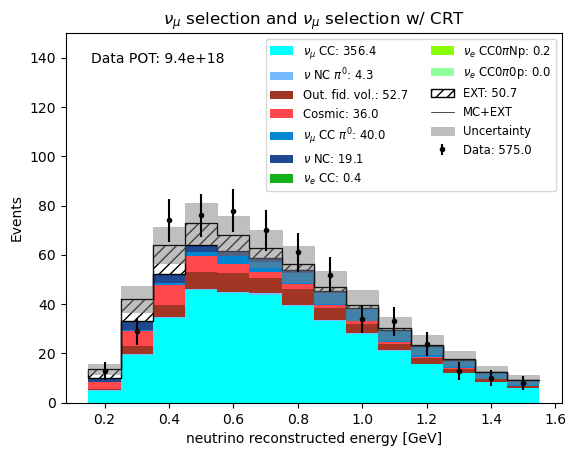

In [5]:
import matplotlib.pyplot as plt

ax = plotter_numu.plot(category_column="category", include_multisim_errors=True, add_ext_error_floor=False, stacked=True, show_total=True)
ax.set_ylim((0, 150))
# plt.savefig("plots/numu_sideband_with_drt_run3_crt.pdf")

In [6]:
# RUN = [1, 2, 3]
RUN = ["3"]
all_truth_filters = [
    "nue",
    "drt",
    # remove the ones below to save some time
    # "nc_pi0",
    # "cc_pi0",
    # "cc_nopi",
    # "cc_cpi",
    # "nc_nopi",
    # "nc_cpi",
]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    truth_filtered_sets=all_truth_filters,
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
)

get_rundict: run_number= 1
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/nuepresel/PostCRTFix_bnb_beam_off_peleeTuple_uboone_v08_00_00_70_run3.root


../../data_loading.py:1107: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1107: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:623: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:623: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


is_mc= False
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/nuepresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root


../../data_loading.py:786: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, np.nan)


is_mc= True
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/nuepresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_nue.root
is_mc= True
get_rundict: run_number= 3
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/nuepresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_dirt.root
is_mc= True
get_rundict: run_number= 3
Loading lee sample
Using data_paths.yml to locate ntuple file
get_rundict: run_number= 3
Loading ntuple file /Volumes/LaCie/PELEE_2023_Samples/run3/nuepresel/overlay_peleeTuple_uboone_v08_00_00_70_run3_nue.root
is_mc= True
get_rundict: run_number= 3
get_rundict: run_number= 1
get_rundict: run_number= 3


In [7]:
selection = "NPBDT"
preselection = "NP"
# binning_def = ("reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]")
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")  # reproduce technote
binning = hist.Binning.from_config(*binning_def)
signal_generator = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=numu_generator,
    uncertainty_defaults=None,
)
plotter = rp.RunHistPlotter(signal_generator, selection_title=None)
plotter.title = plotter.get_selection_title(selection=selection, preselection=preselection)

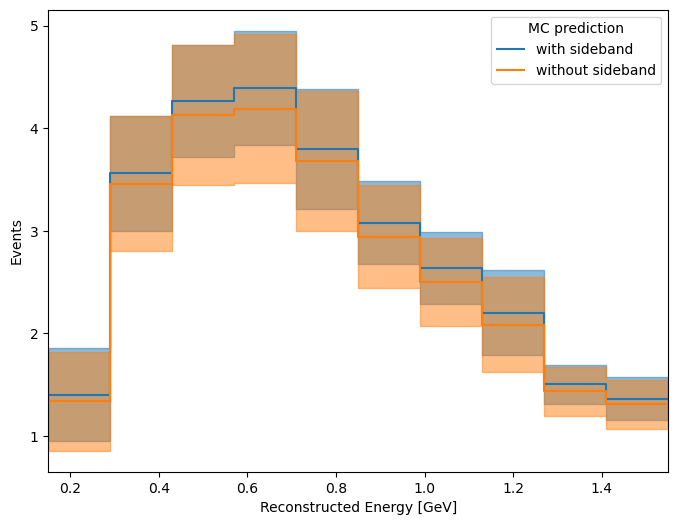

In [8]:
prediction_without_sideband = signal_generator.get_mc_hist(include_multisim_errors=True, use_sideband=False)
prediction_with_sideband = signal_generator.get_mc_hist(include_multisim_errors=True, use_sideband=True)

fig, ax = plt.subplots(figsize=(8, 6))
prediction_with_sideband.draw(ax=ax, label="with sideband")
prediction_without_sideband.draw(ax=ax, label="without sideband")
ax.legend(title="MC prediction")


(0.0, 10.0)

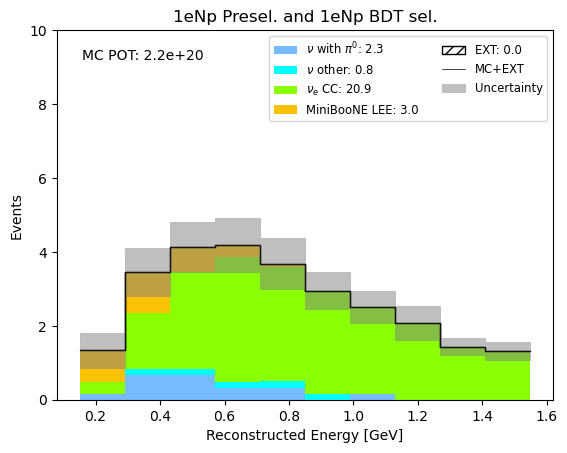

In [9]:
ax = plotter.plot(
    category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=False
)
ax.set_ylim((0, 10))

(0.0, 10.0)

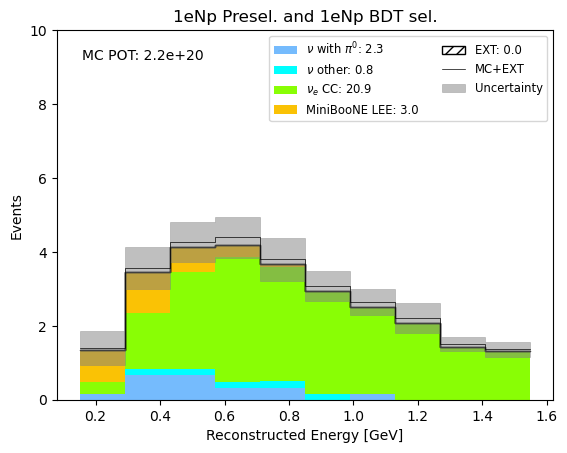

In [10]:
ax = plotter.plot(
    category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=True
)
ax.set_ylim((0, 10))

In [11]:
selection = "ZPBDT"
preselection = "ZP"
# binning_def = ("reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]")
# binning = hist.Binning.from_config(*binning_def)
signal_generator_zp = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=numu_generator,
    uncertainty_defaults=None,
)
plotter_zp = rp.RunHistPlotter(signal_generator_zp, selection_title=None)
plotter_zp.title = plotter.get_selection_title(selection=selection, preselection=preselection)

<AxesSubplot:title={'center':'1e0p Presel. and 1e0p BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

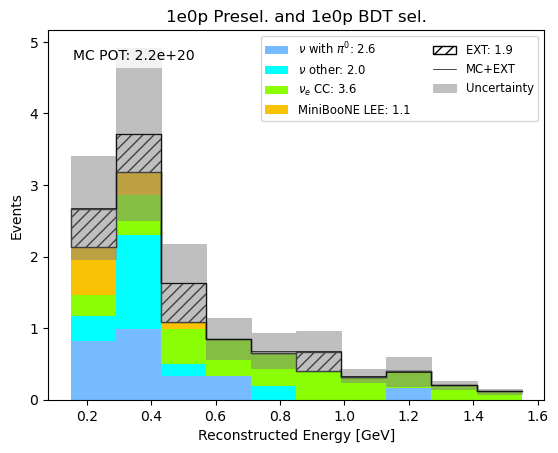

In [12]:
plotter_zp.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=True)

In [13]:
# we can also extract the histogram generators and from those get the multiband covariance matrices
sideband_hist_gen = numu_generator.get_hist_generator(which="mc")
np_hist_gen = signal_generator.get_hist_generator(which="mc")
zp_hist_gen = signal_generator_zp.get_hist_generator(which="mc")

In [14]:
ms_column = "weightsFlux"
hist_gens = [np_hist_gen, zp_hist_gen, sideband_hist_gen]
multiband_covariance = hist.HistogramGenerator.multiband_covariance(
    hist_gens,
    ms_column=ms_column
)

In [15]:
import numpy as np
# convert the covariance into a correlation matrix
with np.errstate(divide='ignore', invalid='ignore'):
    multiband_correlation = multiband_covariance / np.sqrt(np.outer(np.diag(multiband_covariance), np.diag(multiband_covariance)))
# replace NANs with 0s
multiband_correlation = np.nan_to_num(multiband_correlation)

In [16]:
multiband_correlation

array([[ 1.        ,  0.73973781,  0.80424266, ..., -0.11553438,
        -0.02219058,  0.04945318],
       [ 0.73973781,  1.        ,  0.90485843, ...,  0.38071531,
         0.42392849,  0.46643843],
       [ 0.80424266,  0.90485843,  1.        , ...,  0.27180237,
         0.33348807,  0.38236679],
       ...,
       [-0.11553438,  0.38071531,  0.27180237, ...,  1.        ,
         0.98505152,  0.97301769],
       [-0.02219058,  0.42392849,  0.33348807, ...,  0.98505152,
         1.        ,  0.9924522 ],
       [ 0.04945318,  0.46643843,  0.38236679, ...,  0.97301769,
         0.9924522 ,  1.        ]])

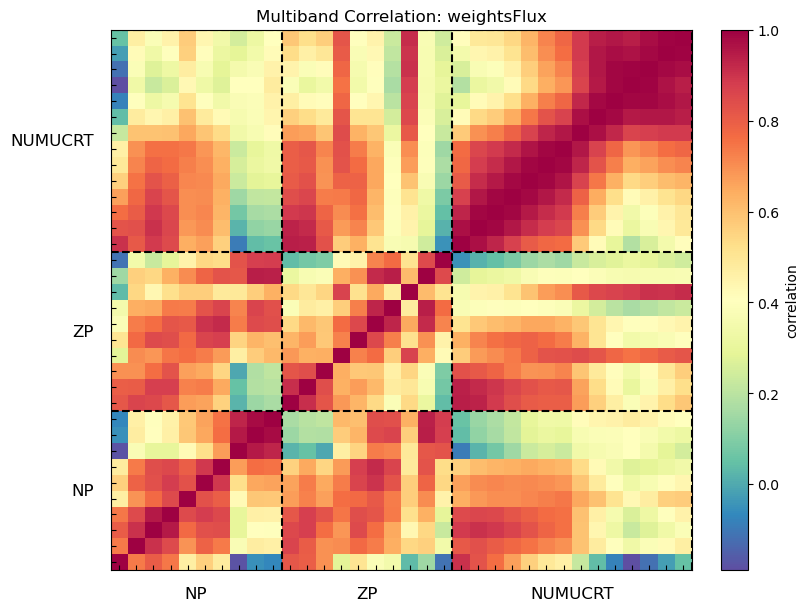

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# show the covariance matrix as a heatmap
X, Y = np.meshgrid(np.arange(multiband_correlation.shape[0] + 1), np.arange(multiband_correlation.shape[1] + 1))
p = ax.pcolormesh(X, Y, multiband_correlation.T, cmap="Spectral_r", shading="flat")
# colorbar
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("correlation")
ax.set_title(f"Multiband Correlation: {ms_column}")
# turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
# set tick marks at every bin
ax.set_xticks(np.arange(multiband_correlation.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(multiband_correlation.shape[1]) + 0.5, minor=False)
ax.tick_params(axis='both', which='both', direction="in")


# draw vertical and horizontal lines splitting the different histograms that went
# into the covariance matrix
pos = 0
hist_gen_labels = ["NP", "ZP", "NUMUCRT"]
for hist_gen, label in zip(hist_gens, hist_gen_labels):
    pos += hist_gen.binning.n_bins
    ax.axvline(pos, color="k", linestyle="--")
    ax.axhline(pos, color="k", linestyle="--")
    ax.text(pos - hist_gen.binning.n_bins / 2, -1, label, ha="center", va="top", fontsize=12)
    ax.text(-1, pos - hist_gen.binning.n_bins / 2, label, ha="right", va="center", fontsize=12)

plt.savefig(f"plots/multiband_correlation_{ms_column}_numu_crt.pdf")